In [1]:
import pandas as pd
from scipy import stats

## import data

[Human resources in science and technology by sex, country](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240613-2).

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

European health interview survey. [Working hours per week](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240530-1).

In [3]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

Purchasing power parities (PPPs), price level indices and real expenditures. [Household consumption, price levels](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240620-2).

In [4]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

Enterprises by detailed NACE Rev.2 activity and special aggregates. [People employed in finance and insurance](https://ec.europa.eu/eurostat/en/web/products-eurostat-news/w/ddn-20240610-2).

In [5]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [6]:
pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])

,0
geo,
AT,0.500863
BA,0.510067
BE,0.526191
BG,0.582070
CH,0.493922
CY,0.529859
CZ,0.492497
DE,0.519083
DK,0.502393


In [7]:
def process_csv(df):
    return (df
            .query("geo in ('AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI','FR','HR','HU','IE','IT','LT','LU','LV','MT','NL','NO','PL','PT','RO','RS','SE','SI','SK')")
            .set_index('geo')[['OBS_VALUE']]
           )

In [8]:
def normalised(df):
    return (df-df.min())/(df.max()-df.min())


 G7: Canada, France, Germany, Italy, Japan, the United Kingdom and the United States. Of which the relevant to Eurostat data are France, Germany, Italy.

In [30]:
merged_stats=(lfsa_ewhais
 #.assign(g7=lfsa_ewhais.geo.where(lfsa_ewhais.geo in ('FR','DE','IT')))
 .pipe(process_csv)
 .pipe(normalised)
 .rename(columns={"OBS_VALUE":"weekly_h"})
 .assign(fem_scitech=pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])
         .pipe(normalised),
         prices=prc_ppp_ind
        .pipe(process_csv)
        .pipe(normalised),
         financiers=sbs_ovw_act
        .pipe(process_csv)
        .pipe(normalised),
         east_west=pd.Series(data=['W','W','E','E','E','W','W','E','E','W','W','W','E','E','W','W','E','W','E',
                             'W','W','W','E','W','E','E','W','E','E'],
                             index=['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
                             'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK']),
         g7=pd.Series(data=['g7','g7','g7'],
                             index=['DE', 'FR', 'IT'])
        )
             )
        
              #.reset_index()
              #.query('geo!="EU27_2020"')


In [31]:
merged_stats


,weekly_h,fem_scitech,prices,financiers,east_west,g7
geo,,,,,,
AT,0.147368,0.329388,0.104843,0.084115,W,NaN
BE,0.284211,0.462405,0.133622,0.100104,W,NaN
BG,0.715789,0.755865,0.043274,0.030555,E,NaN
CY,0.663158,0.481671,0.004649,0.021477,E,NaN
CZ,0.589474,0.285452,0.083822,0.170359,E,NaN
DE,0.189474,0.425074,1.000000,0.549482,W,g7
DK,0.221053,0.337424,0.062298,0.105421,W,NaN
EE,0.442105,0.883553,0.006039,0.020405,E,NaN
EL,0.800000,0.470062,0.080706,0.108884,E,NaN


# visualise data

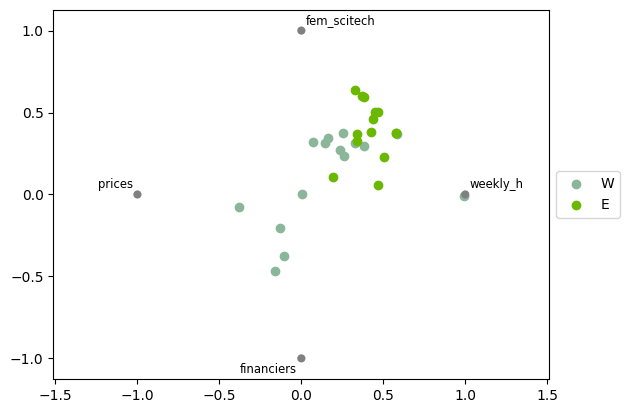

In [33]:
pd.plotting.radviz(merged_stats.drop(columns='g7'),'east_west').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
#,colors={'W':'tab_bluew','E':'tab_red'}

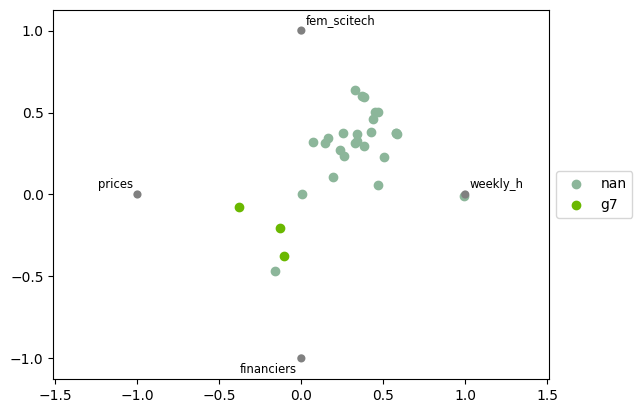

In [52]:
pd.plotting.radviz(merged_stats.drop(columns='east_west'),'g7').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
#,colors={'W':'tab_bluew','E':'tab_red'}

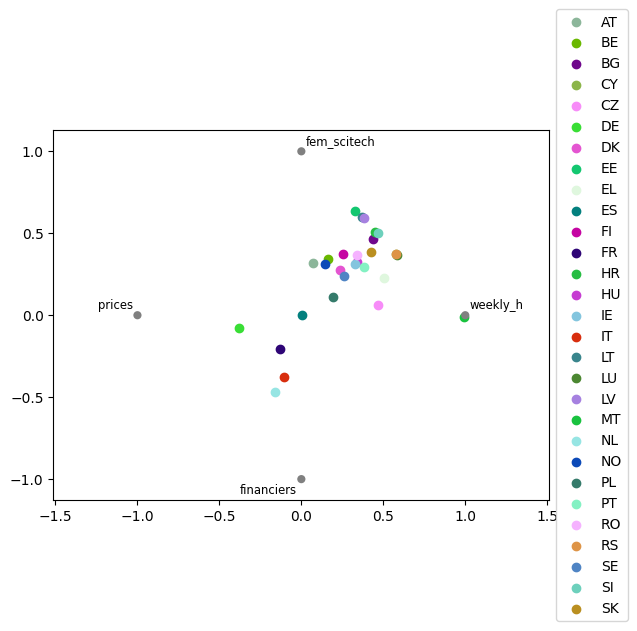

In [35]:
pd.plotting.radviz(merged_stats.drop(columns=['east_west','g7']).reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


parallel coordinates crowded for prices and financiers near 0.0-0.2, this corresponds to the bottom left quadrant of the radviz being empty? And likewise busy top right radviz quadrant correspond to the many lines at 0.2-1.0 for weekly hours and females in science and technology. 

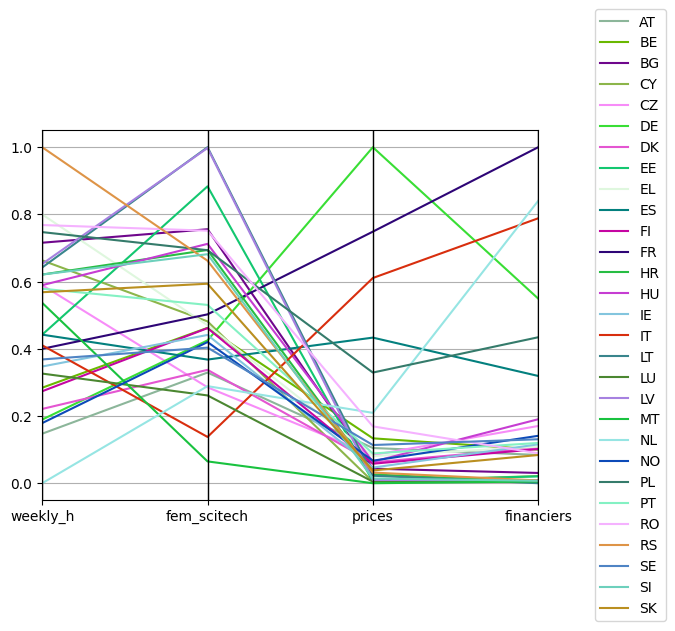

In [36]:
pd.plotting.parallel_coordinates(merged_stats.drop(columns=['east_west','g7']).reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.1, 0.5))

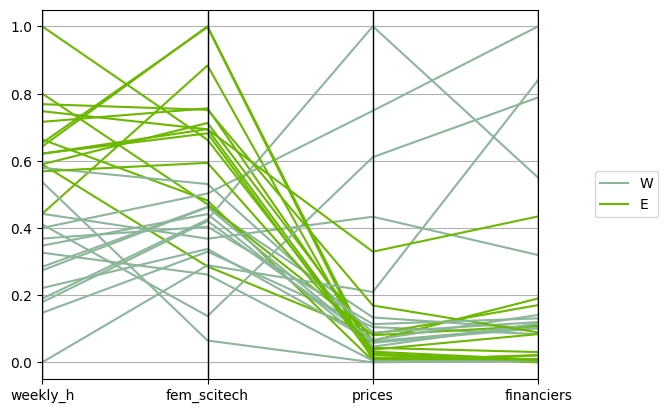

In [37]:
pd.plotting.parallel_coordinates(merged_stats.drop(columns='g7'),'east_west').legend(loc='center left',bbox_to_anchor=(1.1, 0.5))

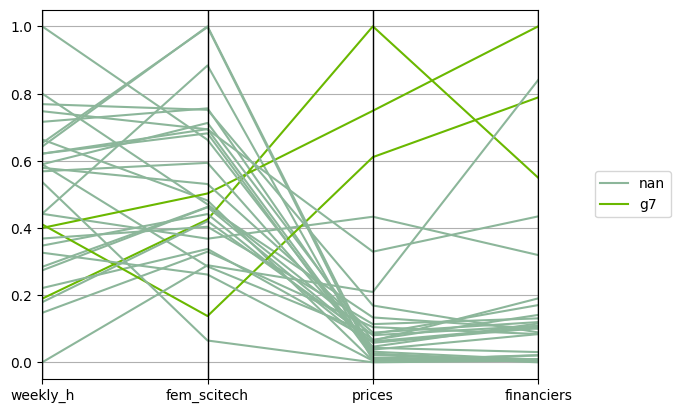

In [53]:
pd.plotting.parallel_coordinates(merged_stats.drop(columns='east_west'),'g7').legend(loc='center left',bbox_to_anchor=(1.1, 0.5))

In [38]:
merged_stats['financiers'].sort_values(ascending=False).iloc[0:4]

geo
FR    1.000000
NL    0.840365
IT    0.788511
DE    0.549482
Name: financiers, dtype: float64

In [39]:
merged_stats['prices'].sort_values(ascending=False).iloc[0:4]

geo
DE    1.000000
FR    0.748723
IT    0.610768
ES    0.433347
Name: prices, dtype: float64

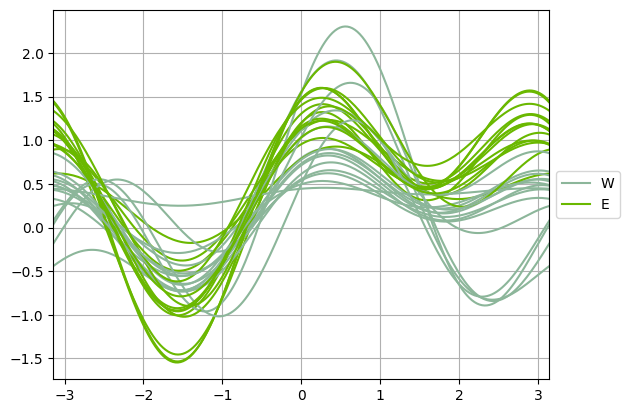

In [40]:
pd.plotting.andrews_curves(merged_stats.drop(columns='g7'),'east_west').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

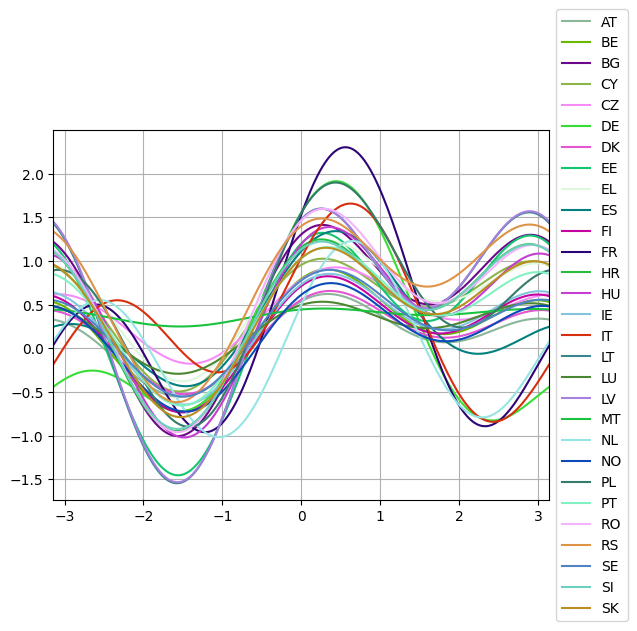

In [41]:
pd.plotting.andrews_curves(merged_stats.drop(columns=['east_west','g7']).reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

> $ f(t) = \frac{x_1}{\sqrt{2}} + x_2 \sin(t) + x_3 \cos(t) + x_4 \sin(2t) + x_5 \cos(2t) + \cdots $
Where x coefficients correspond to the values of each dimension
and t is linearly spaced between $ -\pi$ and $+\pi$ .
Each row of frame then corresponds to a single curve.

So the first coefficient is the dc component, the next two the in phase and quadrature component of the fundamental, and the next one the in phase component of the first harmonic. 
- The few countries with significant contribution to first harmonic create the trough after 2, which are the same as the ones with high value of people working in finance and insurance.
- Phase differences between the other countries are due to how females in science and technology compares to prices.

In [42]:
#import yellowbrick

# Correlations

Core EU countries: France, Germany, Italy. Expensive, and with a lot of people working in finance/insurance. Leading countries in these two dimensions stand out from the rest and from each other.

Eastern European countries (with geographic definition, including historic NATO member Greece, non aligned former Yugoslavia and Cyprus): People work long hours, much higher percentage of women in science and technology. These dimensions form a continuum, most east european countries occupy the top half of the continuum but there is no clear clustering

In [47]:
#pd.plotting.scatter_matrix(
merged_stats.drop(columns=['east_west','g7'])
#)

,weekly_h,fem_scitech,prices,financiers
geo,,,,
AT,0.147368,0.329388,0.104843,0.084115
BE,0.284211,0.462405,0.133622,0.100104
BG,0.715789,0.755865,0.043274,0.030555
CY,0.663158,0.481671,0.004649,0.021477
CZ,0.589474,0.285452,0.083822,0.170359
DE,0.189474,0.425074,1.000000,0.549482
DK,0.221053,0.337424,0.062298,0.105421
EE,0.442105,0.883553,0.006039,0.020405
EL,0.800000,0.470062,0.080706,0.108884


In [48]:
merged_stats.drop(columns=['east_west','g7']).corr()

,weekly_h,fem_scitech,prices,financiers
weekly_h,1.000000,0.525280,-0.281540,-0.382036
fem_scitech,0.525280,1.000000,-0.250826,-0.335678
prices,-0.281540,-0.250826,1.000000,0.804731
financiers,-0.382036,-0.335678,0.804731,1.000000


In [49]:
stats.linregress(merged_stats['fem_scitech'],y=merged_stats['weekly_h'])

LinregressResult(slope=0.5195813497557528, intercept=0.2166020608571118, rvalue=0.525279875558356, pvalue=0.0034335929653707643, stderr=0.16198488829582536, intercept_stderr=0.09213076082652073)

In [50]:
financiers_vs_prices_lreg=stats.linregress(merged_stats['prices'],y=merged_stats['financiers'])

In [51]:
financiers_vs_prices_lreg

LinregressResult(slope=0.8928174118766177, intercept=0.05094038211332175, rvalue=0.8047313631736963, pvalue=1.425190550643427e-07, stderr=0.12675128524817708, intercept_stderr=0.0363830315680913)

In [ ]:
#stats.bootstrap()